https://minassaleh.github.io/

## Louisiana Hydrographic Data Analysis
#### Mina Saleh and Ryan Park

### Project Description

Our final project for our data science class this semseter will take a look at studies of Lousiana hydrographic data. Extensive studies have been made to record water data in the region of Lousiana. With access to data recorded by the Coastal Protection and Restoration Authority (CPRA), we can analyze some fundamental attributes pertaining to the water, namely the water level, the water's temperature, and the quality of the water by looking at the pH and salaninty. This data has been collected across a variety of research sites, with several years of recorded data for each. The data is avaialable [here](https://cims.coastal.louisiana.gov/DataDownload/DataDownload.aspx?type=hydro_monthly). We will also obtain hourly water level data from the same website.

### Project Plan

We already have a means of scraping the data sources provided by the CPRA. The next step is to isolate some relevant sites and make studies on them. At a foundational level, our program will record the desired hydrographic variables (water level, temperature, and quality) versus time. We can use visuals to survey various trends, and make more complex rate analysis later. For example, how is the rate of temperature change varying across a period of five years? Moreso, with the location of the measurement sites specified, we could link intresting results to local industrial endeavours. Furthermore, the CPRA has made signifcant endeavours to counter the threat of growing land erosion, available here: https://cims.coastal.louisiana.gov/outreach/projects/OPL_Full_page.html. With the data we have, we can attempt to understand the impact of each project. Ultimately, This project aims to use what we are learning throughout the class to provide an overview of the local water situation in the Lousiana area with the help of sensory data gathered by the CPRA. Our aim is to provide a more accessible overview of the fundamental data they have exracted, and then draw our own insight based on what we have. One possible goal of this project would be to make a recommendation to the local glass recycling organization, Glass Half Full Nola, who are interested in depositing recycled sand as a means to restore barrier islands that protect the mainland from storm surge and other storm related disasters. Where is the most useful place to deposit GHF sand? What size should the sand particles be?

In regards to our collaboration effort so far, we have already set up a private Github repository to update the code. We have met in person severals times to plan out and scope the project. Moving forward we will be meeting in person and on zoom to continuously update the project. 

The data below is monthly hydographic data recorded by the CPRA across a collection of sites, as part of various projects. The data contains various water attributes. For now, we will focus on temperature, elevation, pH, and salinity. The data was difficult to gather at first, since they are only accessible by submitting an e-mail request for each project. This was circumvented by using a bot. With the raw data extracted, the next step was to combine the project csv's into a single csv, and read that as a dataframe. This data frame was cleaned by removing extraneous attributes, replacing empty strings with NaNs, and combining the date and time.  

We have already isolated the table, which has an enormous collection of data, and cleaned it with what we currently intend to use. Moving forward, we will work on isolating several station ID's, and their associated data. We can then use the data we obtain from each station to understand the development of the water situation at that location.

### Imports

In [5]:
import os
from os import listdir as ls
from os.path import join as pjoin
import re
import requests
import time

from bs4 import BeautifulSoup as bs
from fake_useragent import UserAgent
import geopandas as gpd
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.proxy import Proxy, ProxyType

### Webscraping

In [4]:
# Get information from CPRA coastal protection authority. m
hydro_monthly = requests.get(
    "https://cims.coastal.louisiana.gov/DataDownload/DataDownload.aspx?type=hydro_monthly"
)

In [5]:
def get_free_proxies():
    """Due to https://stackoverflow.com/questions/59409418/how-to-rotate-selenium-webrowser-ip-address"""
    driver = webdriver.Chrome()
    driver.get('https://sslproxies.org')
    table = driver.find_element(By.TAG_NAME, 'table')
    thead = table.find_element(By.TAG_NAME, 'thead').find_elements(By.TAG_NAME, 'th')
    tbody = table.find_element(By.TAG_NAME, 'tbody').find_elements(By.TAG_NAME, 'tr')
    headers = [th.text.strip() for th in thead]
    proxies = []
    for tr in tbody:
        proxy_data = {}
        tds = tr.find_elements(By.TAG_NAME, 'td')
        for i in range(len(headers)):
            proxy_data[headers[i]] = tds[i].text.strip()
        proxies.append(proxy_data)
    driver.close()
    return [f"{pr['IP Address']}:{pr['Port']}" for pr in proxies]


def setup_driver(ip=None, random_user=False):
    driver_specs = {"options": Options()}
            
    if ip:
        # Rotating proxy
        prox = Proxy()
        prox.proxy_type = ProxyType.MANUAL
        prox.http_proxy = ip
        capabilities = webdriver.DesiredCapabilities.CHROME
        prox.add_to_capabilities(capabilities)
        driver_specs["desired_capabilities"] = capabilities
    if random_user:
        # Rotating user-agent
        driver_specs["options"].add_argument(
            f"user-agent={UserAgent().random}")
    return webdriver.Chrome(**driver_specs)
    
           
def chrome_bot(rotate_ip=False):
    email = "rpark1@tulane.edu"
    # Get the name of each project for field extract
    projects = re.findall("[A-Z]{2}-[0-9]{4}[\ -].*\)", hydro_monthly.text) # \([0-9]{2}/.*\)
    # Optional Start condition
    projects = projects[projects.index("BA-0170 - BREACH MANAGEMENT PLAN (05/15/2007 to 08/24/2021 [2,419])"):]
    for p in projects:
        # Start chrome bot.
        driver = setup_driver()
        # Go to CPRA.
        driver.get("https://cims.coastal.louisiana.gov/DataDownload/DataDownload.aspx?type=hydro_monthly")
        # Check off for long/lat data
        driver.find_element_by_id("MainContent_CB_StationLatLong").click()
        # Select project.
        driver.find_element_by_id("MainContent_DDL_ProjectList").send_keys(p)
        # Press download
        driver.find_element_by_id("MainContent_BTN_DownLoad").click()
        try:
            # File small enough to auto extract.
            # Name the extract file
            driver.find_element_by_id("MainContent_TB_Filename").send_keys(p.split()[0])
            # Submit extraction 
            driver.find_element_by_id("MainContent_BTN_OkFilename").click()
        except:
            # Otherwise must go through email.
            driver.find_element_by_id("MainContent_TB_OkCancelEmailInfo").send_keys(email)
            # Submit
            driver.find_element_by_id("MainContent_BTN_OkCancelEmailOk").click()
        # Close for next request.
        time.sleep(1.1)
        driver.close()

# Download each project found on the website locally, named into zip files after each project
# Note: some of these zip files are too big and get emailed to the email specified in chrome_bot
# chrome_bot()
# Was it worth it ??? no # update: yes...?

### Assembly and Tidying

In [4]:
# After unzipping and renaming emailed files, we are left with csv files.
def combine_from_zip():
    # Concatonate csv files and create project column.
    # My data location currently # TODO: decide on dir structure in github.
    hydro_m_path = pjoin("data", "CPRA_Hydro_Monthly")
    # data from storage
    for f in ls(hydro_m_path):
        print(f)
        # Skip non csv.
        if ".csv" not in f:
            continue
        fpath = pjoin(hydro_m_path, f)
        subdf = pd.read_csv(fpath, encoding="latin1")
        hydmon = hydmon.append(subdf)
combine_from_zip()
hydmon.head()

NotADirectoryError: [Errno 20] Not a directory: '/Users/Mina/Documents/GitHub/ACOMP/hydro.csv'

In [7]:
hydmon=pd.read_csv("/Users/Mina/Documents/GitHub/ACOMP/hydro.csv")
hydmon.head()

,Unnamed: 0,CPRA Station ID,Measurement Depth (ft),Staff Gauge (ft),Water Temperature (°C),Specific Conductance (uS/cm),Salinity (ppt),pH (pH units),Latitude,Longitude,Datetime
0,0,CRMS6304-P01,0.328,0.67,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-10-19 10:40:00
1,1,CRMS6304-P01,0.328,2.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-11-12 13:51:00
2,2,CRMS6304-P01,0.984,2.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-11-12 13:51:00
3,3,CRMS6304-P01,0.328,1.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-12-28 12:31:00
4,4,CRMS6304-P01,0.984,1.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-12-28 12:31:00


In [8]:
# Focus on only the columns we care about
cols = ["CPRA Station ID", "Date (mm/dd/yyyy)", "Time (hh:mm)", "Measurement Depth (ft)",
        "Staff Gauge (ft)", "Water Temperature (°C)", "Specific Conductance (uS/cm)",
        "Salinity (ppt)", "pH (pH units)", "Latitude", "Longitude"]
# print(hydmon["Time Zone"].unique()) # all CST
# hydmon = hydmon[cols]
if "Time (hh:mm)" in hydmon.columns:
    # Create datetime columns
    hydmon.loc[:, "Datetime"] = pd.to_datetime(
    hydmon["Date (mm/dd/yyyy)"] + "_" + hydmon["Time (hh:mm)"],
    format="%m/%d/%Y_%H:%M")
    hydmon = hydmon.drop(["Time (hh:mm)", "Date (mm/dd/yyyy)"], axis=1)
hydmon

,Unnamed: 0,CPRA Station ID,Measurement Depth (ft),Staff Gauge (ft),Water Temperature (°C),Specific Conductance (uS/cm),Salinity (ppt),pH (pH units),Latitude,Longitude,Datetime
0,0,CRMS6304-P01,0.328,0.67,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-10-19 10:40:00
1,1,CRMS6304-P01,0.328,2.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-11-12 13:51:00
2,2,CRMS6304-P01,0.984,2.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-11-12 13:51:00
3,3,CRMS6304-P01,0.328,1.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-12-28 12:31:00
4,4,CRMS6304-P01,0.984,1.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-12-28 12:31:00
...,...,...,...,...,...,...,...,...,...,...,...
3276393,879,CRMS0261-V51,0.984,NaN,NaN,NaN,NaN,NaN,29.601989,-90.104419,2018-08-07 11:23:00
3276394,880,CRMS0261-V51,0.328,0.56,NaN,NaN,NaN,NaN,29.601989,-90.104419,2019-08-20 13:06:00
3276395,881,CRMS0261-V51,0.984,0.56,NaN,NaN,NaN,NaN,29.601989,-90.104419,2019-08-20 13:06:00
3276396,882,CRMS0261-V51,0.328,1.58,NaN,NaN,NaN,NaN,29.601989,-90.104419,2021-08-19 13:25:00


,Unnamed: 0,CPRA Station ID,Measurement Depth (ft),Staff Gauge (ft),Water Temperature (°C),Specific Conductance (uS/cm),Salinity (ppt),pH (pH units),Latitude,Longitude,Datetime,depth_gradient,geometry
0,0,CRMS6304-P01,0.328,0.67,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-10-19 10:40:00,NaN,POINT (-91.27905 29.42031)
1,1,CRMS6304-P01,0.328,2.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-11-12 13:51:00,NaN,POINT (-91.27905 29.42031)
2,2,CRMS6304-P01,0.984,2.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-11-12 13:51:00,NaN,POINT (-91.27905 29.42031)
3,3,CRMS6304-P01,0.328,1.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-12-28 12:31:00,NaN,POINT (-91.27905 29.42031)
4,4,CRMS6304-P01,0.984,1.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-12-28 12:31:00,NaN,POINT (-91.27905 29.42031)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3276393,879,CRMS0261-V51,0.984,NaN,NaN,NaN,NaN,NaN,29.601989,-90.104419,2018-08-07 11:23:00,NaN,POINT (-90.10442 29.60199)
3276394,880,CRMS0261-V51,0.328,0.56,NaN,NaN,NaN,NaN,29.601989,-90.104419,2019-08-20 13:06:00,NaN,POINT (-90.10442 29.60199)
3276395,881,CRMS0261-V51,0.984,0.56,NaN,NaN,NaN,NaN,29.601989,-90.104419,2019-08-20 13:06:00,NaN,POINT (-90.10442 29.60199)
3276396,882,CRMS0261-V51,0.328,1.58,NaN,NaN,NaN,NaN,29.601989,-90.104419,2021-08-19 13:25:00,NaN,POINT (-90.10442 29.60199)


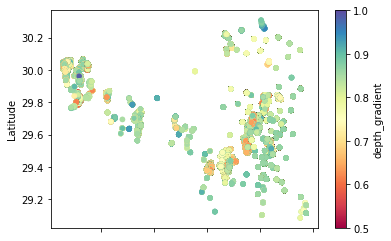

In [35]:
# Create a quick plot to look at where these sites are located.
def map_range(df, x):
    normlin = (df[x] - df[x].min()) / (df[x].max() - df[x].min())
    shift = normlin*0.5 + 0.5
    return shift

hydmon.loc[:, "depth_gradient"] = map_range(hydmon, "Water Temperature (°C)")
display(hydmon)

hydmon.plot.scatter(x="Longitude", y="Latitude", c="depth_gradient", cmap=cm.get_cmap("Spectral"));
plt.show()

### Site Locations
We will start by getting an overview of where our sites are located

Text(0.5, 1.0, 'Lousiana site study locations')

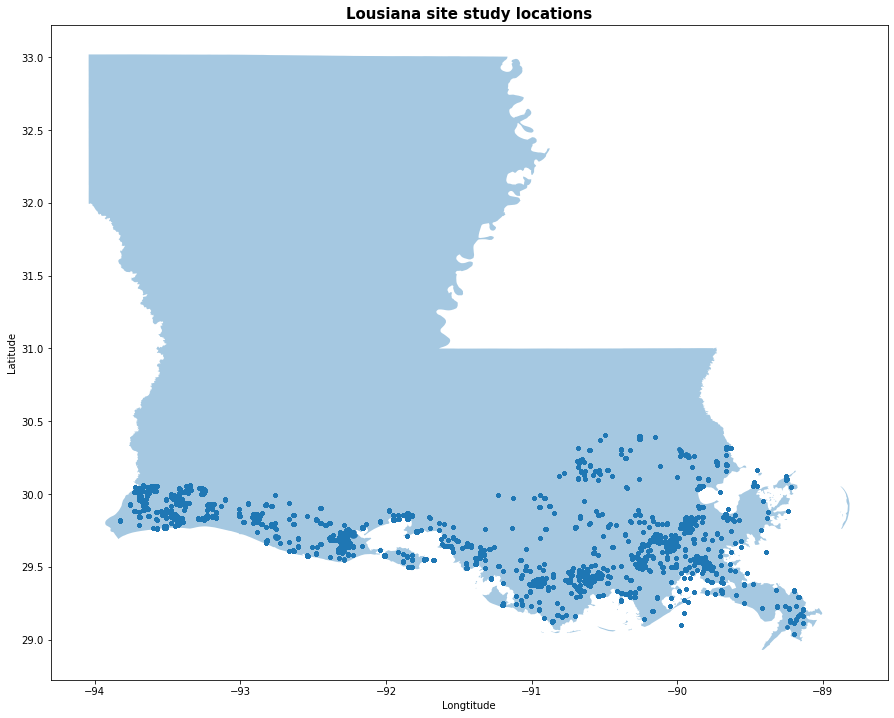

In [42]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
states = gpd.read_file('/Users/Mina/Documents/GitHub/ACOMP/MinaSSaleh.github.io/cb_2017_us_state_500k')
type(states)
geometry = [Point(xy) for xy in zip(hydmon["Longitude"], hydmon["Latitude"])]
geo_df = gpd.GeoDataFrame(hydmon,geometry = geometry)
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xlabel("Longtitude")
ax.set_ylabel("Latitude")
states[states['NAME'] == 'Louisiana'].plot(ax=ax, alpha=0.4)
geo_df.plot(ax=ax,alpha=0.5, legend=True,markersize=10)
plt.title("Lousiana site study locations", fontsize=15,fontweight="bold")



### Exploratory Data Analysis: Location Variance
Since our project plans to recommend the best possible erosion protection strategy per water research site, we will start by looking at how varied the sites we are looking at actually are. 

We will first take a look at the staff gauge.Staff gauges signify how deep the water level at a particular site are. Having staff gauge data can be useful for identifying the water level development at a particular site. Additionally, as used below, examining the stagg gauge records can be useful for developing a preliminary idea on the uniformity of protection measures. 

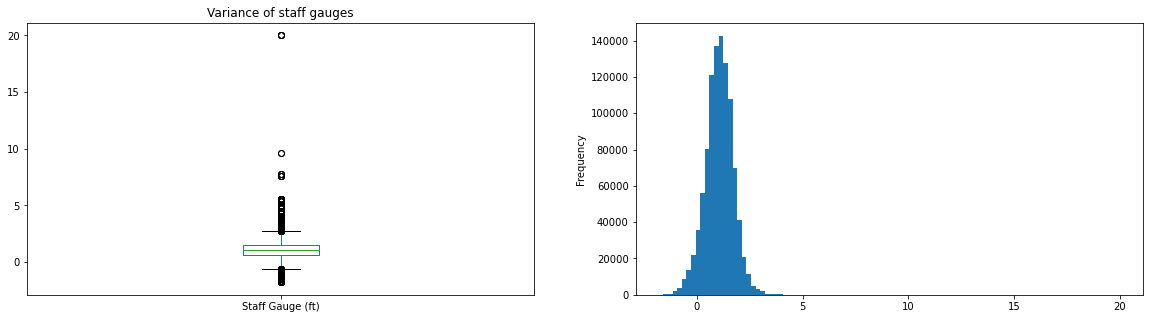

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
fig1 = hydmon["Staff Gauge (ft)"].plot.box(ax = ax[0], title="Variance of staff gauges")
fig2 = hydmon["Staff Gauge (ft)"].plot.hist(bins = 100) 

Let's apply a similar sort of analysis to each of the pH and salinity. The water's pH will not necassarily make a difference in how suceptible an area is to flooding, or erosion, but can impact the choice of protection strategy. 

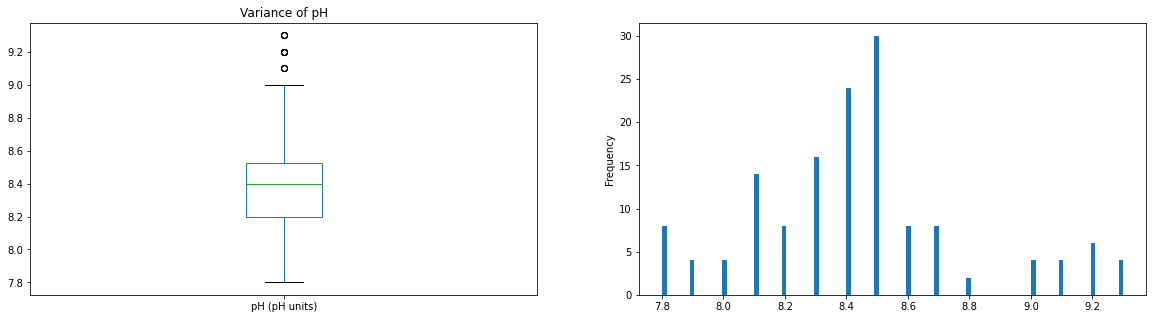

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
fig1 = hydmon["pH (pH units)"].plot.box(ax = ax[0], title="Variance of pH")
fig2 = hydmon["pH (pH units)"].plot.hist(bins = 100)

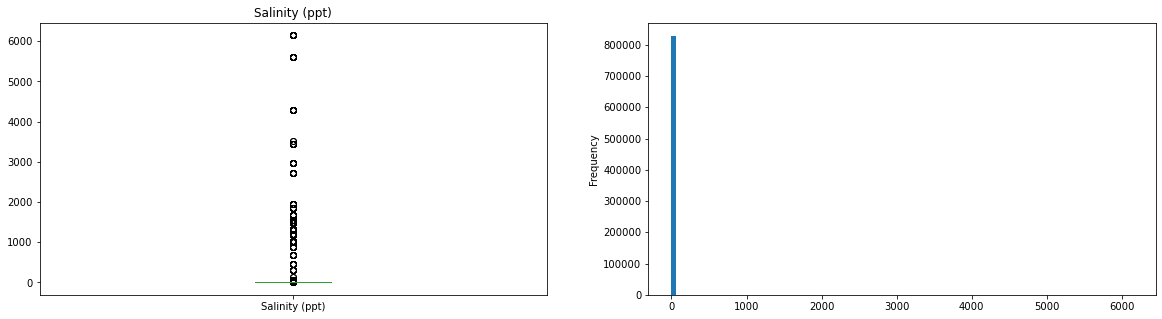

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
fig1 = hydmon["Salinity (ppt)"].plot.box(ax = ax[0], title="Salinity (ppt)")
fig2 = hydmon["Salinity (ppt)"].plot.hist(bins = 100)